In [1]:
# Erasmus+ ICCT project (2018-1-SI01-KA203-047081)

# Toggle cell visibility

from IPython.display import HTML
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide()
    } else {
        $('div.input').show()
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Promijeni vidljivost <a href="javascript:code_toggle()">ovdje</a>.''')
display(tag)

# Hide the code completely

# from IPython.display import HTML
# tag = HTML('''<style>
# div.input {
#     display:none;
# }
# </style>''')
# display(tag)

In [2]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import sympy as sym

from ipywidgets import widgets, Layout
from ipywidgets import interact

from IPython.display import Latex, display, Markdown # For displaying Markdown and LaTeX code

from matplotlib import patches

## Sustav upravljanja položajem azimuta antene

Primjer jednostavnog sustava upravljanja položajem azimuta antene shematski je prikazan na slici ispod (lijevo). Cilj ovog upravljačkog sustava je zadržati referentni (željeni) položaj antene postavljanjem željenog kuta $\theta_{ref}$ referentnim potenciometrom (RP). Stoga, blok-dijagram ovog sustava (prikazan na slici dolje desno) započinje signalom $\theta_{ref}$, koji se pretvara u napon $U_1$. Napon $U_2$ tada se oduzima od napona $U_1$. $U_2$ je izlaz iz mjernog potenciometra (MP) koji pruža informacije o stvarnom kutu. Razlika napona $U_1-U_2$ predstavlja pogrešku koja nam kazuje koliko se stvarni kut razlikuje od željenoga. Na temelju ove pogreške kontroler upravlja elektromotorom koji (pomoću zupčanika) zakreće antenu s ciljem smanjenja iznosa pogreške. $d_w$ predstavlja smetnju uslijed vjetra koji nasumično zakreće antenu.

<br>
<br>

<table>
    <tr>
        <th>Shematski prikaz sustava upravljanja položajem azimuta antene</th>
        <th>Blok-dijagram sustava upravljanja položajem azimuta antene</th>
    </tr>
    <tr>
        <td><img src='img\antenna_azimuth_schematic_hr.png'></td>
        <td><img src='img\antenna_azimuth_block-diagram_hr.png'></td>
    </tr>
    <tr>
        <td></td>
        <td>Legenda: RP-referentni potenciometar, MP-mjerni potenciometar, d<sub>w</sub>-smetnja uzrokovana vjetrom.</td>
    </tr>    
</table>

---

### Kako koristiti ovaj interaktivni primjer?

- Upotrijebite klizače za promjenu vrijednosti željenog kuta/azimuta antene ($\theta_{ref}$), smetnje uzrokovane vjetrom ($d_w$), te proporcionalnog ($K_p$), integracijskog ($K_i$) i derivacijskog ($K_d$) koeficijenta podešavanja.

- Aktivirajte gumbe za promjenu proporcionalnog (P), proporcionalno-integracijskog (PI) i proporcionalno-integracijsko-derivacijskog (PID) tipa kontrolera.

---

### Napomene

- Veličina crvene strelice na shematskom prikazu antene proporcionalna je veličini smetnje uzrokovane vjetrom ($d_w$), dok smjer strelice predstvlja smjer dotične smetnje.
- Isprekidana plava crta na shematskom prikazu antene označava stvarni kut antene.
- Isprekidana zelena crta na shematskom prikazu antene označava željeni kut antene.
- Isprekidano-točkasta crvena crta na crtici na shematskom prikazu antene označava prethodni stvarni kut antene.

Moguće je izabrati između dvije ponuđene opcije za prikaz rezultata:
1. Resetiranje shematskog prikaza kada se promijeni tip kontrolera.
2. Resetiranje grafa kada se promijeni tip kontrolera.

In [3]:
# define system constants
_Kpot = 0.318

_K1 = 100
_a = 100
_Km = 2.083
_am = 1.71
_Kg = 0.1
_R = 8
_Kt = 0.5
_Tv = 200 #in milliseconds

#set current theta and theta reference:
th = [0,0,0,0,0,0]
thref = [0,0,0,0,0,0]
# disturbance:
m = [0,0,0,0,0,0]
#joined together (first theta reference, second disturbance, then theta measured):
variables = [thref, m, th]

# variables of controller:
_K = 1
_taui = 1
_taud = 1


In [4]:
# symbolic calculus:
taui, taud, K, s, z = sym.symbols('taui, taud, K, s, z')

_alpha=0.1
#controller:
P = K
I = K/(taui*s)
D = K*taud*s/(_alpha*taud*s+1)

def make_model(controller):
    if controller == 'P':
        C = P
    elif controller == 'PI':
        C = P+I
    elif controller == 'PID':
        C = P+I+D
    else:
        print('Tip kontrolera ne nalazi se u koristenoj knjiznici')
    
    tf_s = C*_K1*_Km*_Kg*_Kpot/(s*(s+_a)*(s+_am)+C*_K1*_Km*_Kg*_Kpot)
    tf_s = tf_s.simplify()

    tf_z = tf_s.subs(s,2/(_Tv/1000)*(z-1)/(z+1))
    tf_z = tf_z.simplify()
    
    num = [sym.fraction(tf_z.factor())[0].expand().coeff(z, i) for i in reversed(range(1+sym.degree(sym.fraction(tf_z.factor())[0], gen=z)))]
    den = [sym.fraction(tf_z.factor())[1].expand().coeff(z, i) for i in reversed(range(1+sym.degree(sym.fraction(tf_z.factor())[1], gen=z)))]
    #print(num)
    #print(den)

    tf_sM = _Km*_Kg*_R*(s+_a)/(s*(s+_a)*(s+_am)*_Kt+C*_K1*_Km*_Kg*_Kpot*_Kt)
    
    tf_zM = tf_sM.subs(s,2/(_Tv/1000)*(z-1)/(z+1))
    tf_zM = tf_zM.simplify()
    num_M = [sym.fraction(tf_zM.factor())[0].expand().coeff(z, i) for i in reversed(range(1+sym.degree(sym.fraction(tf_zM.factor())[0], gen=z)))]
    #print(num_M)
    #print(den_M)
    
    #print('\n........finished........')
    return sym.lambdify((K, taui, taud), [np.array(num), -np.array(num_M), -np.array(den)])

z_transform_p = make_model('P')
z_transform_pi = make_model('PI')
z_transform_pid = make_model('PID')

In [5]:
def calculate_next(z_transform):
    variables[-1][0] = 0 # set current to zero
    z_transform = z_transform(_K, _taui, _taud)
    
    temp = 0
    for i in range(len(z_transform)): # for every polynomial
        for j in range(len(z_transform[i])): # for every term in polynomial
            temp += z_transform[i][j] * variables[i][j]

    return temp / z_transform[-1][0]*(-1)

<IPython.core.display.Javascript object>


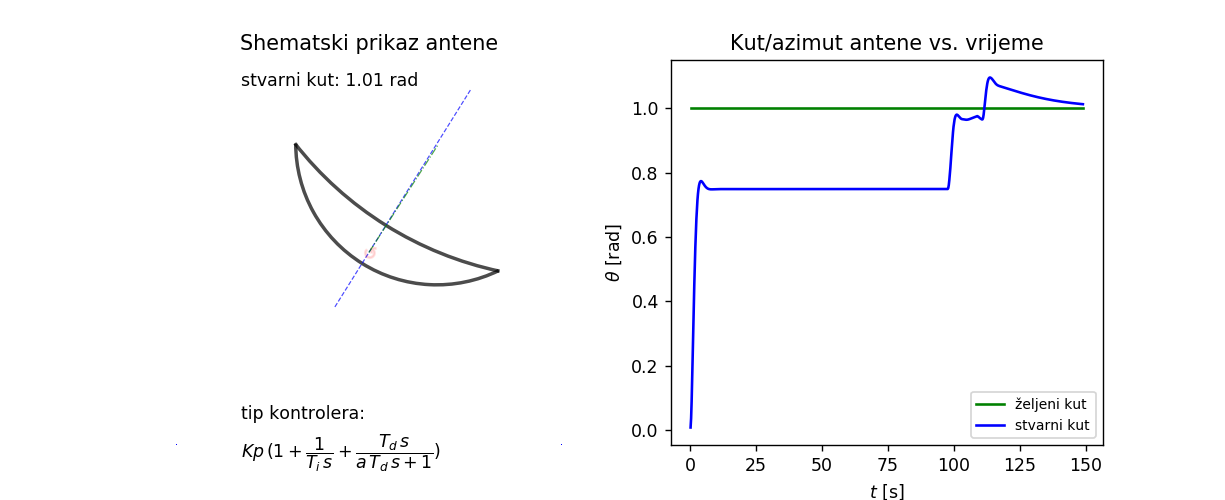

ToggleButtons(description='Odaberi tip kontrolera:', options=('P', 'PI', 'PID'), style=ToggleButtonsStyle(desc…

In [6]:
fig = plt.figure(figsize=(9.8, 4),num='Sustav upravljanja položajem azimuta antene')
# add axes
ax = fig.add_subplot(121)
graph = fig.add_subplot(122)
    
#set current theta and theta reference:
th = [0,0,0,0,0,0]
thref = [1,0,0,0,0,0]
# disturbance:
m = [.1,0,0,0,0,0]
#joined together (first theta reference, second disturbance, then theta measured):
variables = [thref, m, th]

# variables of controller:
_K = 20
_taui = 10
_taud = 1

new_flag_value = [True, 0] # flag for displaying old value of th, before th_ref was changed [flag, angle]

#slider widgets:
th_ref_widget = widgets.FloatSlider(value=variables[0][0],min=0.0,max=2*np.pi,step=.01,description=r'\(\theta_{ref} \) [rad]',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f')
m_widget = widgets.FloatSlider(value=variables[1][0],min=-.3,max=.3,step=.01,description=r'\(d_{w} \)',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f')
K_widget = widgets.FloatSlider(value=_K,min=0.0,max=40,step=.1,description=r'\(K_p \)',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.1f')
taui_widget = widgets.FloatSlider(value=_taui,min=0.01,max=60,step=.01,description=r'\(K_i \)',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f')
taud_widget = widgets.FloatSlider(value=_taud,min=0.0,max=5,step=.1,description=r'\(K_d \)',
                    disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='.2f')
#interact(set_coefficients, setK=K_widget, setthref=th_ref_widget, setm=m_widget, settaui=taui_widget, settaud=taud_widget)

#checkboxes
#checkbox_reset_antenna = widgets.Checkbox(value=False, description='Reset schematic representation of antenna when type of controller is changed', disabled=False)
#checkbox_reset_graph = widgets.Checkbox(value=False, description='Reset graph when type of controller is changed', disabled=False)

checkbox_reset_antenna = widgets.Checkbox(value=False, disabled=False, layout=Layout(width='100px'))
label_scheme = widgets.Label('Resetiranje shematskog prikaza kada se promijeni tip kontrolera', layout=Layout(width='500px'))
box1 = widgets.HBox([checkbox_reset_antenna, label_scheme])
                             
checkbox_reset_graph = widgets.Checkbox(value=False, disabled=False, layout=Layout(width='100px'))
label_graph = widgets.Label('Resetiranje grafa "Kut/azimut antene vs. vrijeme" kada se promijeni tip kontrolera', layout=Layout(width='500px'))
box2 = widgets.HBox([checkbox_reset_graph, label_graph])

style = {'description_width': 'initial'}

#buttons:
def buttons_clicked(event):
    global controller_type, equation, list_th, list_th_ref, list_time
    controller_type = buttons.options[buttons.index]
    if controller_type =='P':
        taui_widget.disabled=True
        taud_widget.disabled=True
        equation = '$Kp$'
    if controller_type =='PI':
        taui_widget.disabled=False
        taud_widget.disabled=True
        equation = '$Kp\,(1+\dfrac{1}{T_{i}\,s})$'
    if controller_type =='PID':
        taui_widget.disabled=False
        taud_widget.disabled=False
        equation = '$Kp\,(1+\dfrac{1}{T_{i}\,s}+\dfrac{T_{d}\,s}{a\,T_{d}\,s+1})$'
    if checkbox_reset_antenna.value:
        #reset values to zero:
        for i in range(len(variables)):
            for j in range(1, len(variables[i])):
                variables[i][j] = 0
        variables[-1][0] = 0
    if checkbox_reset_graph.value:
        list_th = []
        list_th_ref = []
        list_time = []
        
buttons = widgets.ToggleButtons(
    options=['P', 'PI', 'PID'],
    description='Odaberi tip kontrolera:',
    disabled=False,
    style=style)
buttons.observe(buttons_clicked)


#updating values
def set_values(event):
    global _K, _taui, _taud
    if event['name'] != 'value':
        return
    if th_ref_widget.value != variables[0][0] and not new_flag_value[0]:
        new_flag_value[0] = True
        new_flag_value[1] = variables[-1][0]
        
    variables[0][0] = th_ref_widget.value
    variables[1][0] = m_widget.value
    _K = K_widget.value
    _taui = taui_widget.value
    _taud = taud_widget.value
th_ref_widget.observe(set_values)
m_widget.observe(set_values)
K_widget.observe(set_values)
taui_widget.observe(set_values)
taud_widget.observe(set_values)

#displaying widgets:
display(buttons)
vbox1 = widgets.VBox([th_ref_widget, m_widget, K_widget, taui_widget, taud_widget])
vbox2 = widgets.VBox([box1, box2])
hbox = widgets.HBox([vbox1, vbox2])
display(hbox)

#setting at start:
controller_type = 'P'
taui_widget.disabled=True
taud_widget.disabled=True
equation = '$Kp$'
set_values({'name':'value'})

#lists for graph in time:
list_time = []
list_th = []
list_th_ref = []

#previous th before change of th_ref:
prev_th = 0

cycles_flag = True

def update_figure(i_time):
    global cycles_flag, variables, _K, controller_type, equation
    
    if cycles_flag == True:
        cycles_flag = False
        return
    
    if controller_type == 'P':
        th = calculate_next(z_transform_p)
    elif controller_type == 'PI':
        th = calculate_next(z_transform_pi)
    elif controller_type == 'PID':
        th = calculate_next(z_transform_pid)
    variables[-1][0] = th
    
    # save variables for next time step:
    for i in range(len(variables)):
        for j in reversed(range(len(variables[i])-1)):
            variables[i][j+1] = variables[i][j]

    list_time.append((i_time+1)*_Tv/1000)
    list_th.append(th)
    list_th_ref.append(variables[0][0])
    
    #plot:
    ax.clear()
    ax.plot([-1.5, 1.5, 1.5, -1.5], [-1.5, -1.5, 1.5, 1.5], ',', color='b')
    
    #plot line:
    ax.plot([np.cos(th)*-.5, np.cos(th)*1.5], [np.sin(th)*-.5, np.sin(th)*1.5], 'b--', linewidth=.7, alpha=.7)
    
    #plot antenna:
    center1 = 1
    center2 = 3
    d1 = 2.2
    d2 = 5.5
    x1 = center1*np.cos(th)
    y1 = center1*np.sin(th)
    x2 = center2*np.cos(th)
    y2 = center2*np.sin(th)
    arc1 = patches.Arc((x1, y1), d1, d1,
                 angle=th/np.pi*180+180, theta1=-58, theta2=58, linewidth=2, color='black', alpha=.7)
    arc2 = patches.Arc((x2, y2), d2, d2,
                 angle=th/np.pi*180+180, theta1=-20, theta2=20, linewidth=2, color='black', alpha=.7)
    ax.add_patch(arc1)
    ax.add_patch(arc2)
    if m_widget.value > 0:
        ax.plot(0, 0, 'r', alpha=.1, marker=r'$\circlearrowright$',ms=150*m_widget.value)
    elif m_widget.value < 0:
        ax.plot(0, 0, 'r', alpha=.1, marker=r'$\circlearrowleft$',ms=-150*m_widget.value)
    ax.set_title('Shematski prikaz antene')

    
    #plot direction of antenna before thref change
    if abs(variables[0][0] - th) < 0.03:
        new_flag_value[0] = False
    if new_flag_value[0]:
        ax.plot([0,np.cos(new_flag_value[1])], [0, np.sin(new_flag_value[1])], 'r-.', alpha=.3, linewidth=0.5)
    #plot desired direction of antenna
    ax.plot([0,np.cos(variables[0][0])], [0, np.sin(variables[0][0])], 'g-.', alpha=.7, linewidth=0.7)
    
    ax.text(-1, 1.3, 'stvarni kut: %.2f rad' %th)
    ax.text(-1, -1.3, 'tip kontrolera:')
    ax.text(-1, -1.6, equation)
    
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.axis('off')
    
    graph.clear()
    graph.plot(list_time, list_th_ref, 'g', label='željeni kut')
    graph.plot(list_time, list_th, 'b', label='stvarni kut')    
    graph.set_xlabel('$t$ [s]')
    graph.set_ylabel('$\\theta$ [rad]')
    graph.legend(loc=4, fontsize=8)
    graph.set_title('Kut/azimut antene vs. vrijeme')
    
    plt.show()

ani = animation.FuncAnimation(fig, update_figure, interval=_Tv)